In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

os.chdir('/Volumes/GoogleDrive/My Drive/BEAM-CORE/BEAM Validation')

plt.style.use('ggplot')

In [2]:
# load austin radar data for validation
link_to_NPMRDS_data = 'data for validation/SF/NPMRDS/'
NPMRDS_data_file = 'sf_npmrds_data.csv'
SF_NPMRDS_data = read_csv(link_to_NPMRDS_data + NPMRDS_data_file, sep = ',')
# load BEAM output
modeled_vmt = read_csv('sample output/SFB2014/0.linkstats.csv.gz', low_memory=False)
model_network = read_csv('sample output/SFB2014/beam_network_npmrds_screenline.csv', low_memory=False)

SF_NPMRDS_data.head(5)

Unnamed: 0   tmc_code   measurement_tstamp  speed  average_speed  \
0           1  105N13022  2018-10-01 06:00:00  16.25           13.0   
1           2  105N13022  2018-10-01 07:00:00  14.40           12.0   
2           3  105N13022  2018-10-01 08:00:00   9.54            9.0   
3           4  105N13022  2018-10-01 09:00:00  15.03           10.0   
4           5  105N13022  2018-10-01 10:00:00  29.47           10.0   

   reference_speed  travel_time_seconds  
0             38.0                13.25  
1             38.0                14.95  
2             38.0                22.57  
3             38.0                14.33  
4             38.0                 7.31

In [3]:
# select observed data for validation
list_of_tmcs = model_network.loc[:, 'Tmc'].unique()
SF_NPMRDS_data = SF_NPMRDS_data.loc[SF_NPMRDS_data['tmc_code'].isin(list_of_tmcs)]
SF_NPMRDS_data.loc[:, 'formatted_time'] =pd.to_datetime(SF_NPMRDS_data.loc[:, 'measurement_tstamp'], 
                                                                        format="%Y-%m-%d %H:%M:%S")
SF_NPMRDS_data.loc[:, 'weekday'] = SF_NPMRDS_data.loc[:, 'formatted_time'].dt.weekday
SF_NPMRDS_data.loc[:, 'hour'] = SF_NPMRDS_data.loc[:, 'formatted_time'].dt.hour
SF_NPMRDS_data = SF_NPMRDS_data.loc[SF_NPMRDS_data['weekday'] == 1]

SF_NPMRDS_data.loc[SF_NPMRDS_data['speed']>= 80, 'speed'] = 80

# austin_NPMRDS_data_hourly_volume = austin_NPMRDS_data.groupby(['tmc_code', 'hour'])[['flow_per_lane']].mean()
# austin_NPMRDS_data_hourly_volume.columns = ['Volume (veh/lane/hour)']
# austin_NPMRDS_data_hourly_volume = austin_NPMRDS_data_hourly_volume.reset_index()
SF_NPMRDS_data_hourly_speed = SF_NPMRDS_data.groupby(['tmc_code', 'hour'])[['speed']].mean()
SF_NPMRDS_data_hourly_speed = SF_NPMRDS_data_hourly_speed.reset_index()
SF_NPMRDS_data_hourly_speed.columns = ['Tmc', 'hour', 'Avg.Speed (mph)']

# SF_NPMRDS_data_hourly_speed = pd.merge(austin_NPMRDS_data_hourly_volume,
#                                          austin_NPMRDS_data_hourly_speed,
#                                          on = ['Tmc', 'hour'], how = 'left')
SF_NPMRDS_data_hourly_speed.head(10)

Tmc  hour  Avg.Speed (mph)
0  105+04099     2            7.000
1  105+04099     3           36.130
2  105+04099     4           68.745
3  105+04099     5           62.528
4  105+04099     6           55.990
5  105+04099     7           48.644
6  105+04099     8           52.672
7  105+04099     9           55.920
8  105+04099    10           53.950
9  105+04099    11           54.882

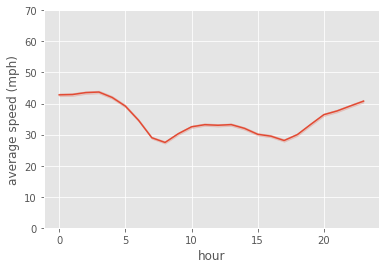

In [5]:
sns.lineplot(data = SF_NPMRDS_data_hourly_speed, x = "hour", y = "Avg.Speed (mph)", ci=95)
plt.ylim([0, 70])
plt.ylabel('average speed (mph)')
plt.savefig('plot/SF_NPMRDS_hourly_mean_speed.png', bbox_inches='tight', dpi = 300)
plt.show()

In [4]:
meter_to_mile = 0.000621371
percent_of_samples = 0.1
mps_to_mph = 2.23694
model_network = model_network.drop_duplicates(subset=['linkId'])
model_network.head(5)

Unnamed: 0  linkId  linkLength  linkFreeSpeed  linkCapacity  numberOfLanes  \
0           1       0     319.764      29.057528          6250            2.5   
1           2       1     319.764      29.057528          6250            2.5   
2           3       2      60.699      21.352000          3450            1.5   
3           4       3      60.699      21.352000          3450            1.5   
4           5      10     157.746      29.057600          2000            1.0   

       linkModes  attributeOrigId attributeOrigType  fromNodeId  toNodeId  \
0       car;bike                1          motorway           0         1   
1       car;bike                1          motorway           1         0   
2  car;walk;bike                2           primary           2         3   
3  car;walk;bike                2           primary           3         2   
4       car;bike               13     motorway_link           8         9   

   GEOID         NAME            NAMELSAD CLASSFP        Tmc  dist_to_tmc  
0   6081    San Mateo    San Mateo County      H1  105P04170          0.0  
1   6081    San Mateo    San Mateo County      H1  105P04170          0.0  
2   6085  Santa Clara  Santa Clara County      H1  105N12931          0.0  
3   6085  Santa Clara  Santa Clara County      H1  105N12931          0.0  
4   6085  Santa Clara  Santa Clara County      H1  105P08309          0.0

In [5]:
# filter modeled network
model_vmt_24_hour = modeled_vmt.loc[(modeled_vmt['hour'] <= 28) & (modeled_vmt['hour'] >= 5)]
model_vmt_24_hour.loc[model_vmt_24_hour['hour']>=24, 'hour'] -= 24
model_network.loc[:, 'fromNodeId'] = model_network.loc[:, 'fromNodeId'].astype(int)
model_network.loc[:, 'toNodeId'] = model_network.loc[:, 'toNodeId'].astype(int)
model_vmt_24_hour = pd.merge(model_vmt_24_hour, model_network, 
                                 left_on = ['link', 'from', 'to'],
                                 right_on = ['linkId', 'fromNodeId', 'toNodeId'], how = 'inner')
model_vmt_24_hour.head(5)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


link  from    to  hour  length  freespeed  capacity stat  volume  \
0  3630  2513  2514   5.0  62.161    18.1168    3300.0  AVG    14.0   
1  3630  2513  2514   6.0  62.161    18.1168    3300.0  AVG    33.0   
2  3630  2513  2514   7.0  62.161    18.1168    3300.0  AVG    52.0   
3  3630  2513  2514   8.0  62.161    18.1168    3300.0  AVG    67.0   
4  3630  2513  2514   9.0  62.161    18.1168    3300.0  AVG    43.0   

   traveltime  ...  attributeOrigId  attributeOrigType  fromNodeId  toNodeId  \
0    3.431125  ...             2875          secondary        2513      2514   
1    5.731012  ...             2875          secondary        2513      2514   
2    3.747120  ...             2875          secondary        2513      2514   
3    3.782844  ...             2875          secondary        2513      2514   
4    3.431125  ...             2875          secondary        2513      2514   

   GEOID     NAME        NAMELSAD  CLASSFP        Tmc  dist_to_tmc  
0   6001  Alameda  Alameda County       H1  105+11197    12.850123  
1   6001  Alameda  Alameda County       H1  105+11197    12.850123  
2   6001  Alameda  Alameda County       H1  105+11197    12.850123  
3   6001  Alameda  Alameda County       H1  105+11197    12.850123  
4   6001  Alameda  Alameda County       H1  105+11197    12.850123  

[5 rows x 27 columns]

In [6]:
demand_scaling = 1/percent_of_samples
model_vmt_24_hour.loc[:, 'hourly volume'] = model_vmt_24_hour.loc[:, 'volume']/ \
model_vmt_24_hour.loc[:, 'numberOfLanes']
model_vmt_24_hour.loc[:, 'VMT'] = demand_scaling * meter_to_mile * model_vmt_24_hour.loc[:, 'linkLength'] * model_vmt_24_hour.loc[:, 'volume']
# model_vmt_24_hour.loc[:, 'travel_time (hr)'] = model_vmt_24_hour.loc[:, 'linkLength'] /3600
model_vmt_24_hour.loc[:, 'speed'] = model_vmt_24_hour.loc[:, 'linkLength'] / model_vmt_24_hour.loc[:, 'traveltime'] 
model_vmt_24_hour.loc[:, 'speed (mph)'] = mps_to_mph * model_vmt_24_hour.loc[:, 'speed']


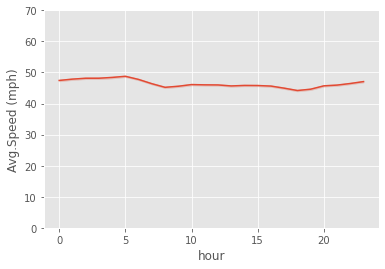

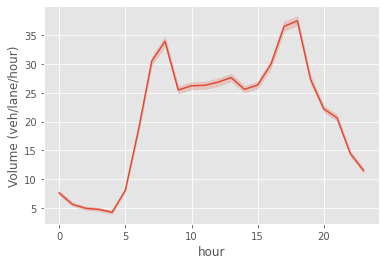

In [7]:
model_vmt_hour_volume = model_vmt_24_hour.groupby(['Tmc', 'hour'])[['hourly volume']].mean()
model_vmt_hour_volume = model_vmt_hour_volume.reset_index()
model_vmt_hour_volume.columns = ['Tmc', 'hour', 'Volume (veh/lane/hour)']
model_vmt_24_hour_filtered = model_vmt_24_hour.loc[model_vmt_24_hour['volume']>0]
model_vmt_hour_speed = model_vmt_24_hour_filtered.groupby(['Tmc', 'hour']).apply(lambda x: np.average(x.speed, weights=x.volume))
model_vmt_hour_speed = model_vmt_hour_speed.reset_index()
model_vmt_hour_speed.columns = ['Tmc', 'hour', 'Avg.Speed (mph)'] 
model_vmt_hour_speed.loc[:, 'Avg.Speed (mph)'] *= mps_to_mph

model_vmt_hour_data = pd.merge(model_vmt_hour_volume, model_vmt_hour_speed,
                               on = ['Tmc', 'hour'], how = 'left')
sns.lineplot(x = 'hour', y = 'Avg.Speed (mph)', data = model_vmt_hour_data, ci = 95)
plt.ylim([0, 70])
plt.savefig('plot/SF2014_modeled_speed_NPMRDS_screenline.png', dpi = 200)
plt.show()

sns.lineplot(x = 'hour', y = 'Volume (veh/lane/hour)', data = model_vmt_hour_data, ci = 95)
# plt.ylim([0, 70])
# plt.ylabel('volume (veh/lane/hour)')
plt.savefig('plot/SF2014_modeled_volume_NPMRDS_screenline.png', dpi = 200)
plt.show()

In [10]:
# compare two datasets
SF_NPMRDS_data_hourly_speed.loc[:, 'source'] = 'NPMRDS'
model_vmt_hour_data.loc[:, 'source'] = 'BEAM output'
combined_data = pd.concat([SF_NPMRDS_data_hourly_speed, model_vmt_hour_data])
combined_data = combined_data.reset_index()
combined_data.head(5)

index        Tmc  hour  Avg.Speed (mph)  source  Volume (veh/lane/hour)
0      0  105+04099   2.0            7.000  NPMRDS                     NaN
1      1  105+04099   3.0           36.130  NPMRDS                     NaN
2      2  105+04099   4.0           68.745  NPMRDS                     NaN
3      3  105+04099   5.0           62.528  NPMRDS                     NaN
4      4  105+04099   6.0           55.990  NPMRDS                     NaN

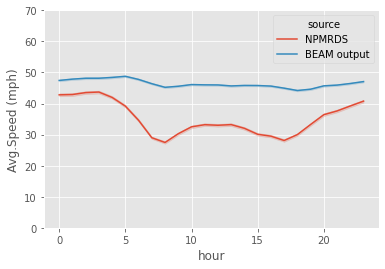

In [11]:
sns.lineplot(x = 'hour', y = 'Avg.Speed (mph)', hue = 'source', data = combined_data, ci = 95)
plt.ylim([0, 70])
plt.savefig('plot/SF2014_BEAM_NPMRDS_screenline_speed_validation.png', dpi = 200)
plt.show()

# sns.lineplot(x = 'hour', y = 'Volume (veh/lane/hour)', hue = 'source', data = combined_data, ci = 95)
# # plt.ylim([0, 70])
# # plt.ylabel('volume (veh/lane/hour)')
# plt.savefig('plot/aus2017_BEAM_NPMRDS_screenline_volume_validation.png', dpi = 200)
# plt.show()

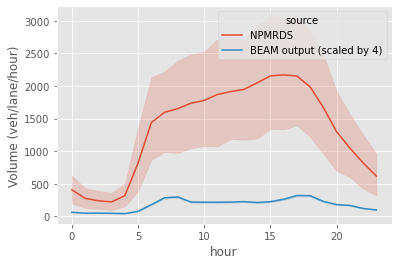

In [12]:
model_vmt_hour_data_scaled = model_vmt_hour_data.copy()
model_vmt_hour_data_scaled.loc[:, 'Volume (veh/lane/hour)'] *= demand_scaling
model_vmt_hour_data_scaled.loc[:, 'source'] = 'BEAM output (scaled by 4)'
#model_vmt_hour_data.loc[:, 'source'] = 'BEAM output'
combined_data_scaled = pd.concat([austin_NPMRDS_data_hourly_data, model_vmt_hour_data_scaled])
combined_data_scaled = combined_data_scaled.reset_index()
combined_data_scaled.head(5)
sns.lineplot(x = 'hour', y = 'Volume (veh/lane/hour)', hue = 'source', 
             data = combined_data_scaled, ci = 95)
# plt.ylim([0, 70])
# plt.ylabel('volume (veh/lane/hour)')
plt.savefig('plot/aus2017_BEAM_NPMRDS_screenline_scaled_volume_validation.png', dpi = 200)
plt.show()

In [8]:
paired_data_for_comparison = pd.merge(SF_NPMRDS_data_hourly_speed, model_vmt_hour_data,
                                      on = ['Tmc', 'hour'], how = 'left')


paired_data_for_comparison = paired_data_for_comparison.rename(columns = {'Avg.Speed (mph)_x': 'SF NPMRDS speed',
                                                                         'Avg.Speed (mph)_y': 'BEAM speed'})
paired_data_for_comparison = paired_data_for_comparison.dropna(subset = ['BEAM speed'])
# paired_data_for_comparison["KITS ID"] = paired_data_for_comparison["KITS ID"].astype(str)
paired_data_for_comparison.head(5)

Tmc  hour  SF NPMRDS speed  Volume (veh/lane/hour)  BEAM speed
0  105+04099     2            7.000                    1.00   70.000116
1  105+04099     3           36.130                    0.50   70.000116
3  105+04099     5           62.528                   11.75   69.361817
4  105+04099     6           55.990                   29.00   66.864628
5  105+04099     7           48.644                   43.50   68.101378

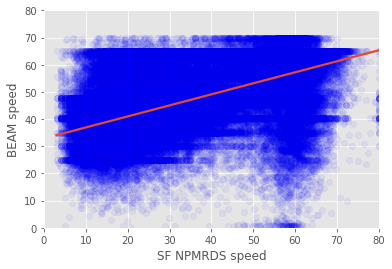

In [24]:
# sns.regplot(data=paired_data_for_comparison, x="Austin NPMRDS volume", y="BEAM volume",
#            scatter_kws={"color": "black", 'alpha':0.5})
# plt.xlim([0, 6000])
# plt.ylim([0, 6000])
# plt.savefig('plot/aus2017_paired_NPMRDS_screenline_volume_validation.png', dpi = 200)
# plt.show()
sns.regplot(data=paired_data_for_comparison, x="SF NPMRDS speed", y="BEAM speed",
           scatter_kws={"color": "blue", 'alpha':0.05})
plt.xlim([0, 80])
plt.ylim([0, 80])
plt.savefig('plot/sf2014_paired_NPMRDS_screenline_speed_validation.png', dpi = 200)
plt.show()

In [15]:
paired_data_to_check = paired_data_for_comparison.loc[(paired_data_for_comparison['BEAM speed']<=5) & \
                                                      (paired_data_for_comparison['SF NPMRDS speed']>= 50)]
paired_data_to_check = pd.merge(paired_data_to_check,
                                model_vmt_24_hour_filtered,
                                on = ['Tmc', 'hour'], how = 'left')
paired_data_to_check = paired_data_to_check.loc[paired_data_to_check['speed (mph)'] <= 5]
paired_data_to_check.to_csv('sample output/SFB2014/selected_link_to_check.csv')

paired_data_to_check.head(5)



Tmc  hour  SF NPMRDS speed  Volume (veh/lane/hour)  BEAM speed  \
0  105+04206     0          57.8000                   250.0    0.576906   
1  105+04206     0          57.8000                   250.0    0.576906   
2  105+04206     1          56.9825                   249.0    0.575077   
3  105+04206     1          56.9825                   249.0    0.575077   
4  105+04206     2          59.9680                   250.0    0.577362   

    link  from    to   length  freespeed  ...  toNodeId GEOID   NAME  \
0  16095  9858  9857  109.536    29.0576  ...      9857  6041  Marin   
1  16094  9857  9858  109.536    29.0576  ...      9858  6041  Marin   
2  16095  9858  9857  109.536    29.0576  ...      9857  6041  Marin   
3  16094  9857  9858  109.536    29.0576  ...      9858  6041  Marin   
4  16095  9858  9857  109.536    29.0576  ...      9857  6041  Marin   

       NAMELSAD  CLASSFP  dist_to_tmc  hourly volume        VMT     speed  \
0  Marin County       H1          0.0          250.0  85.078117  0.257915   
1  Marin County       H1          0.0          250.0  85.078117  0.257884   
2  Marin County       H1          0.0          250.0  85.078117  0.257915   
3  Marin County       H1          0.0          248.0  84.397492  0.256242   
4  Marin County       H1          0.0          250.0  85.078117  0.258292   

   speed (mph)  
0     0.576941  
1     0.576871  
2     0.576941  
3     0.573198  
4     0.577784  

[5 rows x 34 columns]

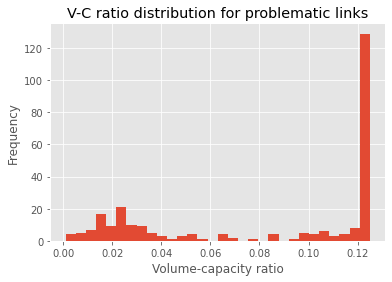

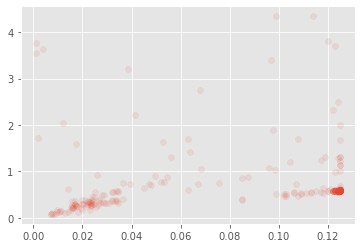

In [19]:
paired_data_to_check.loc[:, 'capacity per lane'] = paired_data_to_check.loc[:, 'capacity'] / paired_data_to_check.loc[:, 'numberOfLanes']
paired_data_to_check.loc[:, 'V-C Ratio'] = paired_data_to_check.loc[:, 'hourly volume']/paired_data_to_check.loc[:, 'capacity per lane']
paired_data_to_check.loc[:, 'V-C Ratio'].hist(bins = 30)
plt.xlabel('Volume-capacity ratio')
plt.ylabel('Frequency')
plt.title('V-C ratio distribution for problematic links')
plt.savefig('plot/vc_ratio_for_problematic_links.png', dpi = 200)
plt.show()
plt.scatter(x='V-C Ratio', y = 'speed (mph)', data = paired_data_to_check, alpha = 0.1)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


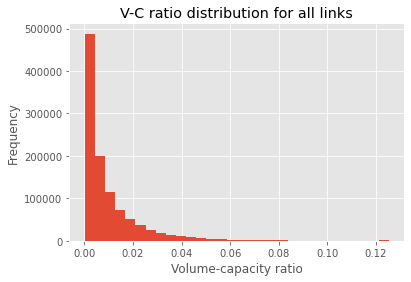

In [21]:
# filter network congested part
model_vmt_24_hour_filtered.loc[:, 'capacity per lane'] = model_vmt_24_hour_filtered.loc[:, 'capacity'] / model_vmt_24_hour_filtered.loc[:, 'numberOfLanes']
model_vmt_24_hour_filtered.loc[:, 'V-C Ratio'] = model_vmt_24_hour_filtered.loc[:, 'hourly volume'] / model_vmt_24_hour_filtered.loc[:, 'capacity per lane']
model_vmt_24_hour_filtered.loc[:, 'V-C Ratio'].hist(bins = 30)
plt.xlabel('Volume-capacity ratio')
plt.ylabel('Frequency')
plt.title('V-C ratio distribution for all links')
plt.savefig('plot/vc_ratio_for_all_sf_links.png', dpi = 200)
plt.show()                               

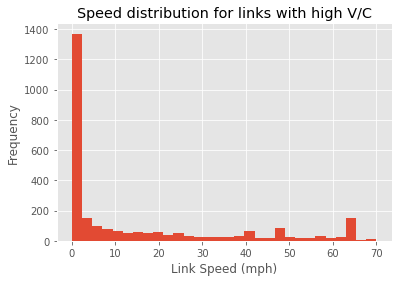

In [23]:
model_vmt_24_hour_congested = model_vmt_24_hour_filtered.loc[model_vmt_24_hour_filtered['V-C Ratio']>= 0.1]
model_vmt_24_hour_congested.loc[:, 'speed (mph)'].hist(bins = 30)
plt.xlabel('Link Speed (mph)')
plt.ylabel('Frequency')
plt.title('Speed distribution for links with high V/C')
plt.savefig('plot/speed_for_congested_sf_links.png', dpi = 200)
plt.show() 

model_vmt_24_hour_congested.to_csv('sample output/SFB2014/links_with_high_vc.csv')